In [1]:
import numpy as np
import scipy.optimize
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Read in data and plot

In [2]:
# load in the data, you will need to change the path to the file
data = pd.read_csv("../../data/competition_experiments/plate_colony_data/colony_counting_20200225.csv")
data["ratio"] = data["wildtype / mL"] / data["delta / mL"]
data["time since start (hr)"] = data["time since start (min)"] / 60
data.head()

,group number,time (hr),time (min),time since start (min),dilution factor,µL plated,number of wildtype colonies,number of delta colonies,wildtype / mL,delta / mL,ratio,time since start (hr)
0,1,10,30,0,10,100,87,106,8700,10600,0.820755,0.00
1,2,10,30,0,10,100,98,110,9800,11000,0.890909,0.00
2,2,11,45,75,10,100,46,42,4600,4200,1.095238,1.25
3,2,12,30,120,10,100,88,107,8800,10700,0.822430,2.00
4,2,13,30,180,10,100,37,21,3700,2100,1.761905,3.00


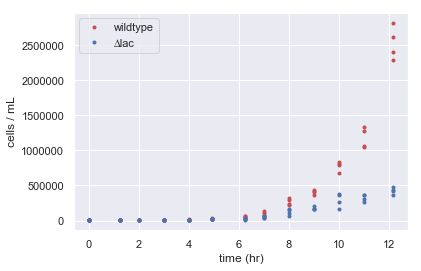

In [3]:
# plot
times = data["time since start (hr)"]
N_wildtype = data["wildtype / mL"]
N_delta = data["delta / mL"]

plt.plot(times, N_wildtype, 'r.')
plt.plot(times, N_delta, 'b.')
plt.xlabel("time (hr)")
plt.ylabel("cells / mL")
plt.legend(["wildtype", "∆lac"]);
plt.savefig('plot.eps')

Great! This looks like what we expected! wildtype is definitely taking over. Now let's consider the ratio of wildtype over the delta strain over time. If these two strains are both growing exponentially, then we expect their ratio to be exponential as well. 

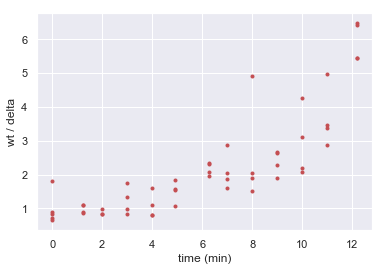

In [4]:
plt.plot(times, data["ratio"], 'r.')
plt.xlabel("time (min)")
plt.ylabel("wt / delta");

## Computing a selection coefficient

As we saw by eye, the wildtype strain takes over. Fitting an expoential to the ratio will elucidate the selection coefficient. The ratio of two exponentially growing strains will look like this over time, where $r_1$ and $r_2$ are the corresponding growth rate:

$$ \frac{N_1(t)}{N_2(t)} = 
\frac{N_1(0) e^{r_1t}}{N_2(0) e^{r_2t}} = 
\frac{N_1(0)}{N_2(0)} e^{(r_1-r_2)t} $$

Let's determine the best fit for data above to get at this difference in growth date, or the selection coefficient. Let's first define an exponetial fucnction, the function we wish to fit.

In [5]:
def exp_curve(times, A, b):
    
    return A * np.exp(b*times)

Now, we will use scipy's optimize function to get the best fit. The inputs to the function are:
- The function we are fitting, `exp_curve()` in this case
- The x-values of our data
- The y-values of our data
- The lower bounds and upper bounds on our parameters (A and b in order)

In [6]:
popt_ratio, _ = scipy.optimize.curve_fit(exp_curve, 
                                         data["time since start (hr)"], 
                                         data["ratio"])

Let's see what parameters we got!

In [7]:
s = np.round(popt_ratio[1],5)
print("Fit for A:", np.round(popt_ratio[0],5))
print("Fit for b:", s, "per hour")

Fit for A: 0.60192
Fit for b: 0.17604 per hour


And let's plot the fit.

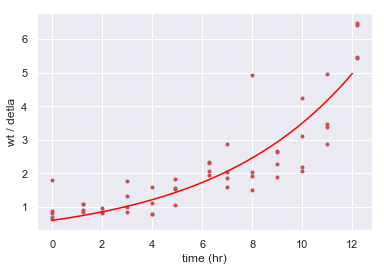

In [8]:
# plot data 
plt.plot(data["time since start (hr)"], data["ratio"], 'r.')

# time values for making a smooth curve
time_range = np.linspace(0, 12, 200)

# plot fits
plt.plot(time_range, exp_curve(time_range, popt_ratio[0], popt_ratio[1]), color="red")
plt.xlabel("time (hr)")
plt.ylabel("wt / detla");
plt.savefig('plot.eps')

## Considering the growth rates independently

### wildtype

In [9]:
popt, _ = scipy.optimize.curve_fit(exp_curve, 
                                         data["time since start (hr)"], 
                                         data["wildtype / mL"])

In [10]:
r_wt = np.round(popt[1],5) 
print("Fit for A:", np.round(popt_ratio[0],5))
print("Fit for b:", r_wt, "per hour")

Fit for A: 0.60192
Fit for b: 0.58395 per hour


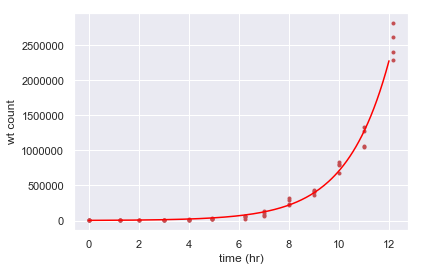

In [11]:
# plot data 
plt.plot(data["time since start (hr)"], data["wildtype / mL"], 'r.')

# time values for making a smooth curve
time_range = np.linspace(0, 12, 200)

# plot fits
plt.plot(time_range, exp_curve(time_range, popt[0], popt[1]), color="red")
plt.xlabel("time (hr)")
plt.ylabel("wt count");

### delta

In [12]:
popt, _ = scipy.optimize.curve_fit(exp_curve, 
                                         data["time since start (hr)"], 
                                         data["delta / mL"])

In [13]:
r_delta = np.round(popt[1],5) 
print("Fit for A:", np.round(popt_ratio[0],5))
print("Fit for b:", r_delta, "per hour")

Fit for A: 0.60192
Fit for b: 0.33135 per hour


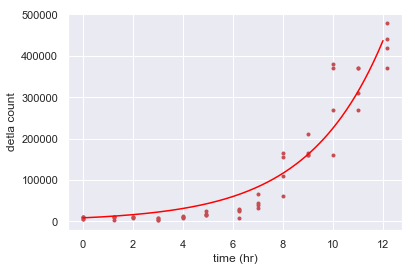

In [14]:
# plot data 
plt.plot(data["time since start (hr)"], data["delta / mL"], 'r.')

# time values for making a smooth curve
time_range = np.linspace(0, 12, 200)

# plot fits
plt.plot(time_range, exp_curve(time_range, popt[0], popt[1]), color="red")
plt.xlabel("time (hr)")
plt.ylabel("detla count");

### Comparing the two approaches 

The selection coefficient should be the difference in the growth rates. Let's check this out:

In [15]:
s

0.17604

In [16]:
r_wt - r_delta

0.2526

Hmmm . . .